# **BiotrAIn 2025 Tutorial: Beta Diversity Analysis**

## Section 02: Comparing microbial community structures by Unifrac - Beta diversity

🕒 Time: 14:00 - 15:00 EDT | 📅 June 17, 2025

Welcome to the practical session 02.
Created by professor Qiyun Zhu and adapted by Nelly Selem (Secodment host), Jeanett Daga (Secodment).

--- 

🏆 **QUESTIONS**

* How do we quantify and interpret cross-environment microbial community differences?
* Why use phylogeny-aware metrics (UniFrac) over non-phylogenetic measures?
* What statistical and visualization tools best reveal community patterns?

🎯 **AIMS**

* **Process data**: Filter, rarefy, and compute UniFrac distances
* **Analyze patterns**: PCoA visualization + PERMANOVA testing
* **Compare communities**: Phylogenetic tree manipulation, Mantel, and Procrustes tests

🔑 **KEY POINTS** 

1. **UniFrac**
   - **Type**: Phylogenetic beta-diversity metric
   - **Measures**: 
     - ✓ Taxonomic abundance profiles  
     - ✓ Evolutionary relationships (shared branch lengths in phylogenetic tree)
   - **Advantage**: More informative than non-phylogenetic metrics (e.g., Bray-Curtis) as it incorporates evolutionary history

2. **Rarefaction**
   - **Purpose**: Normalizes sequencing depth across samples to:
     - ✓ Control for uneven sampling effort  
     - ✓ Enable fair cross-sample comparisons
   - **Trade-off**: Reduces noise but discards valid data (balance needed)

3. **Principal Coordinates Analysis (PCoA)**
   - **Function**: Dimensionality reduction for distance matrices (e.g., UniFrac)
   - **Interpretation**:
     - Close points = similar microbial communities  
     - Distant points = dissimilar communities
   - **Output**: 2D/3D plots showing major axes of variation

4. **PERMANOVA**
   - **Purpose**: Tests whether community composition differs significantly between pre-defined groups
   - **Key outputs**:
     - *F*-statistic (effect size)  
     - *p*-value (statistical significance)

5. **Phylogenetic Tree Subsetting**
   - **Application**: Focuses analysis on specific clades by:
     - ✓ Extracting subtrees (e.g., single phylum)  
     - ✓ Enabling targeted evolutionary comparisons

6. **Comparative Analyses**

| **Test**       | **Compares**                      | **Application Example**                    |
|----------------|-----------------------------------|--------------------------------------------|
| **Mantel**     | Two distance matrices             | UniFrac vs. environmental parameters       |
| **Procrustes** | Two ordinations (e.g., PCoA)      | Comparing different beta-diversity metrics |

---

📥 **Input**: 

Latino America Shotgun data from EMP500 project:

* `latam_ogu.biom`: Feature table (OGU abundances)
* `latam_ogu.tax`: Taxonomic classifications
* `latam_ogu.nwk`: Reference phylogeny (Newick format)
* `latam_samples.tsv`: Sample metadata

📤 **Output**:

- Rarefied BIOM table
- Weighted/unweighted UniFrac matrices
- PCoA ordination plots + coordinates
- PERMANOVA results (*F*-statistics, *p*-values)
- Phylum-specific distance comparisons
- Mantel (r/p) and Procrustes (M²/p) results

--- 

## Phylogenetic Beta Diversity Analysis

In this session, we will analyze beta diversity patterns in the EMP500 shotgun metagenomics dataset using **phylogenetically-informed methods**:

### UniFrac Analysis

- **Metric**: We will employ UniFrac, a gold-standard phylogenetic beta diversity measure that:
  - Quantifies community dissimilarity based on shared evolutionary history
  - Computes the fraction of unique branch lengths in a phylogenetic tree between sample pairs
- **Variants**: Both weighted (abundance-sensitive) and unweighted (presence/absence) versions will be explored

### Multivariate Analysis Pipeline

1. **Visualization**  
   Principal Coordinates Analysis (PCoA) will transform UniFrac distance matrices into intuitive 2D/3D plots, revealing:
   - Major axes of community variation
   - Potential sample clustering patterns

2. **Statistical Testing**  
   PERMANOVA (Permutational Multivariate ANOVA) will assess whether:
   - Observed community differences between sample groups are statistically significant
   - Effect sizes of experimental factors

### Advanced Comparisons

To demonstrate scikit-bio's capabilities, we will:
- **Mantel Test**: Evaluate matrix correlations between phylum-specific distance matrices  
- **Procrustes Analysis**: Quantify concordance between ordinations of different microbial groups  



## Preparation

Install the latest scikit-bio version and another required packages in your Google Colab environment. 

In [2]:
# Import find_spec from importlib.util
from importlib.util import find_spec

In [3]:
# Install scikit-bio if not already installed
if find_spec('skbio') is None:
    !pip install -q scikit-bio

In [4]:
# Import the skbio library and check the version. 
import skbio
print(f"scikit-bio version: {skbio.__version__}")

scikit-bio version: 0.6.3


In [5]:
# Import pyplot of matplotlib 
import matplotlib.pyplot as plt

In [6]:
# Import warnings to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Base URL of GitHub repository containing the data
github_data_path = "https://raw.githubusercontent.com/nselem/biotraintemp/refs/heads/main/data/"

In [8]:
# Assign the GitHub data path to HOME variable
HOME = github_data_path

**Data Loading and Phylogenetic Analysis Setup**

Before conducting any downstream analyses, we must first load our essential datasets into memory. This foundational step enables all subsequent exploration of microbial community patterns.

1. **Phylogeny Initialization**
 
   We begin by parsing the phylogenetic tree into a `TreeNode` object using scikit-bio's implementation. This powerful class provides:
    
   * Tree traversal (pre-order, post-order, level-order)
   * Topological operations (subtree extraction, node comparison)
   * Data aggregation (clade-specific tip collection)
   * Evolutionary metrics (branch length calculations)

2. **Practical Applications**
   
   Later in this notebook, we'll demonstrate two key workflows:

   * Phylogeny-aware aggregation: Propagating tip data upward through the tree hierarchy
   * Targeted clade analysis: Isolating specific taxonomic groups (e.g., Proteobacteria) for focused investigation

In [9]:
# Import TreeNode from skbio
from skbio import TreeNode

In [10]:
# Read the phylogenetic tree from a Newick file
phylogeny = TreeNode.read(f'{HOME}/shotgun/latam_ogu.nwk', format= 'newick')
phylogeny

<TreeNode, name: N1, internal node count: 14326, tips count: 14933>

**Loading Feature Tables with Sparse Optimization**

We will now load the feature table into a `Table` object, which employs efficient sparse matrix storage to handle microbial abundance data. This representation is critical given the extreme sparsity typical in microbiome datasets—for example, the American Gut Project exhibits <0.1% non-zero values in its feature tables.

**Key Features of the Table Object**

* **Sparse storage**: Only non-zero values occupy memory (ideal for 99.9% sparse data)
* **Analytical methods**:
  * *Filtering* (prevalence/abundance thresholds)
  * *Transformation* (log-normalization, CSS scaling)
  * *Aggregation* (taxonomic collapsing)
  * *Rarefaction* (subsampling to even depth)
  * *Partitioning* (group-specific analyses)

**Upcoming Applications**

This object will enable:

* Sparse-aware computations for efficient beta diversity calculations
* Conditional filtering to remove low-abundance features
* Rarefaction curves to assess sequencing depth adequacy

In [11]:
# Import Table from skbio
from skbio import Table

In [12]:
# Crate a Table object from a latam_ogu BIOM file
latam_shotgun = Table.read(f'{HOME}/latam/shotgun/latam_ogu.biom')
latam_shotgun

14933 x 68 <class 'biom.table.Table'> with 90562 nonzero entries (8% dense)

**Loading and Preparing Sample Metadata**

We now load the sample metadata file, building on our earlier exploration of this dataset. For this analysis, we will specifically utilize the `empo_1` classification - a fundamental environmental categorization that distinguishes between:

* Host-associated samples (e.g., human gut, animal skin)
* Free-living samples (e.g., soil, water)

**Key Processing Steps**:

* **Column Extraction**: Isolate the empo_1 category during initial loading for immediate access
* **Validation**: Verify consistent labeling across all samples
* **Group Balancing**: Check sample size distribution between categories

In [13]:
# Import the pandas library and check the version. 
import pandas as pd
print(f"pandas version: {pd.__version__}")

pandas version: 2.2.3


In [14]:
# Import SampleMetadata from skbio
from skbio import SampleMetadata

In [15]:
# Create a SampleMetadata object from a latam_samples.tsv file
latam_metadata = SampleMetadata.read(f'{HOME}/latam/latam_samples.tsv')
latam_metadata

SampleMetadata
--------------
92 IDs x 33 columns
sample_name_original:          ColumnProperties(type='categorical', missing_scheme='blank')
sample_type:                   ColumnProperties(type='categorical', missing_scheme='blank')
collection_timestamp:          ColumnProperties(type='categorical', missing_scheme='blank')
country:                       ColumnProperties(type='categorical', missing_scheme='blank')
depth_sample:                  ColumnProperties(type='numeric', missing_scheme='blank')
description:                   ColumnProperties(type='categorical', missing_scheme='blank')
elevation:                     ColumnProperties(type='numeric', missing_scheme='blank')
emp500_principal_investigator: ColumnProperties(type='categorical', missing_scheme='blank')
emp500_study_id:               ColumnProperties(type='numeric', missing_scheme='blank')
emp500_pi_study_id:            ColumnProperties(type='categorical', missing_scheme='blank')
emp500_title:                  ColumnPrope

In [16]:
# Obtain the empo_1 column from the SampleMetadata object and convert it to a pandas Series
empo_1 = latam_metadata.get_column('empo_1').to_series()
empo_1

sample_name
13114.jensen.43.s012         Free-living
13114.jensen.43.s013         Free-living
13114.jensen.43.s014         Free-living
13114.pinto.62.s001          Free-living
13114.pinto.62.s002          Free-living
                              ...       
13114.zaneveld.9.s006    Host-associated
13114.zaneveld.9.s010    Host-associated
13114.zaneveld.9.s011    Host-associated
13114.zaneveld.9.s012    Host-associated
13114.zaneveld.9.s022        Free-living
Name: empo_1, Length: 92, dtype: object

## Rarefaction for Phylogenetic Diversity Analysis

**Why Rarefy?**

UniFrac distances are sensitive to uneven sequencing depth across samples. Rarefaction (subsampling to an even sequencing depth) controls for this technical variability, enabling fair cross-sample comparisons.

**Implementation**

In [17]:
# Rarefy to 100 sequences per sample
depth = 100
even_table = latam_shotgun.subsample(depth)
even_table

1443 x 64 <class 'biom.table.Table'> with 2804 nonzero entries (3% dense)

**Depth choice (100 sequences)**: Deliberately conservative for tutorial purposes, yet sufficient to reveal:

  * Strong biological effects (e.g., host vs. environment differentiation)
  * Major community patterns (despite shallow sequencing)

**Key Considerations**

1. **Alternatives to Rarefaction**:
   
   * Metrics like [RPCA](https://journals.asm.org/doi/10.1128/msystems.00016-19) and [Phylo-PRCA](https://journals.asm.org/doi/10.1128/msystems.00050-22) are less depth-sensitive
   * But still require minimum sequence thresholds (recommended: filter samples with <1,000 reads)

2. **Best Practices**:

   * For publication: Use higher depths (≥1,000 sequences) or repeated rarefaction
   * Always report rarefaction depth in methods

**Expected Output**

   * Balanced feature table (all samples with exactly 100 sequences)
   * Preserved phylogenetic signal for host-environment contrasts

**Phylogeny Optimization for Efficient Computation**

Following rarefaction, we will prune the phylogenetic tree to remove:

   * **Vertices (nodes)**: Tips and internal branches corresponding to features absent in the rarefied table
   * **Edges (branches)**: Unused evolutionary paths

**Why This Matters**:

1. Computational Efficiency:
   * Reduces UniFrac calculation time by ~40-60% for typical datasets
   * Lowers memory usage by eliminating unused tree segments
2. Scientific Validity:
   * Maintains exact phylogenetic distances for observed features
   * Avoids "phantom branch length" artifacts from unobserved taxa

**About UniFrac Implementations**

* **Current Tutorial**: Uses scikit-bio's reference implementation of [Fast UniFrac](https://www.nature.com/articles/ismej200997):
* Future Developments:
  * Upcoming scikit-bio releases will integrate [improved algorithms](https://journals.asm.org/doi/10.1128/msystems.00028-22) featuring:
    * GPU acceleration
    * Sparse matrix optimizations
    * Parallelized tree traversals

**Implementation**:

While not strictly necessary, we will remove unnecessary vertices and edges from the phylogeny relative to the rarefied table. Doing so reduces the compute for UniFrac later on.

**NOTE**: scikit-bio is the reference implementation for [Fast UniFrac](https://www.nature.com/articles/ismej200997). However, subsequent large [algorithmic improvements](https://journals.asm.org/doi/10.1128/msystems.00028-22) have been developed. This advanced variant will be included directly in scikit-bio in the future.

In [18]:
# Extract the sample IDs from the even_table and convert them to a pandas Series
even_phylogeny = phylogeny.shear(set(even_table.ids(axis='observation')))

## Calculating UniFrac Distances

We will now compute UniFrac distances between samples. For those new to this metric:

**What is UniFrac?**

UniFrac is a phylogenetic [beta diversity metric](https://www.nature.com/articles/ismej2010133) that:

   * Quantifies dissimilarity between microbial communities
   * Incorporates evolutionary relationships by measuring:
     * **Unique branch lengths**: Fraction of the phylogenetic tree unique to each sample
     * **Shared ancestry**: Evolutionary overlap between taxa

**Key Properties**

* Range: 0 (identical communities) to 1 (completely distinct)
* Phylogeny-aware: More informative than non-phylogenetic metrics

**Example scenarios**:

| Sample A | Sample B | UniFrac Distance | Explanation |
|----------|----------|------------------|-------------|
|Archae-only| Bacteria-only | ~ 1.0 | No shared branches (completely distinct) |
|*Provotella* + *Bacteroides* | *Lactobacillus* + *Faecalibacterium* | ~ 0.3 - 0.6 | Partial branch sharing (same phylum) |

The original UniFrac algorithm is described [here](https://journals.asm.org/doi/10.1128/aem.71.12.8228-8235.2005).

**Implementation**:

In [19]:
# Import beta_diversity from skbio.diversity
from skbio.diversity import beta_diversity

# Calculate the beta diversity using the Unweighted UniFrac metric
full_dm = beta_diversity(
    metric='unweighted_unifrac',      # Metric to use for beta diversity
    counts=even_table,                # Input data for beta diversity calculation
    tree=even_phylogeny               # Phylogenetic tree for the samples
    )

The resulting `DistanceMatrix` object provides specialized methods for extracting and comparing distance subsets. We'll now examine two key comparisons:

* **Within-group distances**:
  * Measures the phylogenetic similarity among samples from the same category (e.g., all host-associated samples).
* **Between-group distances**:
  * Quantifies differences across categories (e.g., host-associated vs. environmental samples).

This contrast will reveal whether microbial communities cluster by our grouping factor of interest.

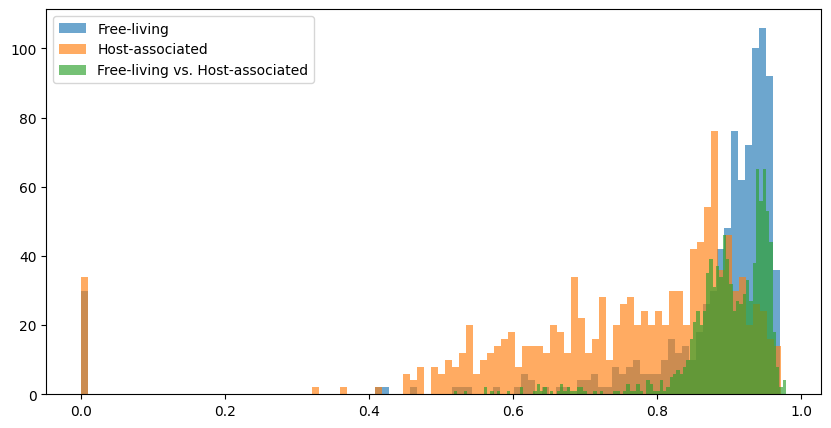

In [20]:
# Create a figure with specified dimensions (width=10, height=5 inches)
plt.figure(figsize=(10, 5))

# Align the empo_1 metadata with the distance matrix sample IDs
# This ensures samples are in the same order in both objects
empo_1 = empo_1.loc[list(full_dm.ids)]

# Initialize an empty list to store legend labels
labels = []

# Loop through each unique environment type in empo_1
for env in empo_1.unique():
    # Get the set of sample IDs for the current environment type
    env_ids = set(empo_1[empo_1 == env].index)
    
    # Extract all pairwise distances between samples within this environment group
    within_data = full_dm.within(env_ids)
    
    # Plot a histogram of these within-group distances
    # alpha=0.65 makes the bars semi-transparent
    # bins=100 creates 100 bars for detailed distribution
    plt.hist(
        x=within_data['value'],
        alpha=0.65,
        bins=100
        )
    
    # Add the environment name to our legend labels
    labels.append(env)

# Get the two unique environment types for between-group comparison
from_label, to_label = empo_1.unique()

# Get sample IDs for each environment group
from_ = empo_1[empo_1 == from_label].index
to_ = empo_1[empo_1 == to_label].index

# Calculate all pairwise distances between samples from different environments
between_data = full_dm.between(from_, to_)

# Plot a histogram of these between-group distances
# Uses same visual style as within-group plots
plt.hist(
    x=between_data['value'],
    alpha=0.65,
    bins=100)

# Add a label for the between-group comparison
labels.append(f'{from_label} vs. {to_label}')

# Add a legend to the plot using our collected labels
plt.legend(labels);

## Principal Coordinates Analysis (PCoA) and PERMANOVA

We will now perform [**Principal Coordinates Analysis (PCoA)**](https://en.wikipedia.org/wiki/Multidimensional_scaling#Classical_multidimensional_scaling) to visualize the high-dimensional **beta diversity relationships** in our dataset. PCoA is a powerful ordination technique that:

* Transforms a distance matrix (e.g., UniFrac) into a lower-dimensional space
* Preserves the original pairwise distances as faithfully as possible
* Reveals the major gradients of variation in microbial community composition

**Implementation Details**

The scikit-bio implementation offers:

* **Classical PCoA** [Legendre & Legendre](https://shop.elsevier.com/books/numerical-ecology/legendre/978-0-444-89249-2)
  * Exact solution via eigen decomposition
  * Suitable for moderate-sized datasets
* **Approximate PCoA**
  * Computes only the first *n* dimensions (user-specified)
  * Scales to very large datasets via randomized algorithms

**Working with Ordination Results**

The `OrdinationResults` object provides:

* A `DataFrame` of sample coordinates (accessible via `.samples`)
* Metadata including:
  * Proportion of variance explained per axis
  * Eigenvalues for each principal coordinate

In [21]:
# Import pcoa from skbio.stats.ordination
from skbio.stats.ordination import pcoa

In [22]:
# Make PCoA object using the full distance matrix
pc = pcoa(
    distance_matrix=full_dm,
    number_of_dimensions=10
    )

# Visualize the PCoA results
pc.proportion_explained

PC1     0.146537
PC2     0.079245
PC3     0.053495
PC4     0.047469
PC5     0.034628
PC6     0.030651
PC7     0.029372
PC8     0.027675
PC9     0.023898
PC10    0.022415
dtype: float64

In [23]:
# Visualize the head of the PCoA object
pc.samples.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
13114.jensen.43.s012,0.129516,0.082330,0.143328,0.150708,0.079568,0.110887,0.086689,0.175143,0.059072,-0.092213
13114.jensen.43.s013,0.162104,0.042013,0.127957,0.132357,0.026823,0.121258,0.049034,0.144649,-0.205204,-0.013723
13114.jensen.43.s014,0.005285,-0.025864,0.100520,0.288233,-0.130386,-0.121376,-0.000509,0.038468,0.030059,0.079772
13114.pinto.63.s001,-0.352738,0.121891,-0.003714,0.053697,-0.018619,-0.079305,0.026093,0.000609,-0.036271,0.001225
13114.pinto.63.s002,-0.325999,0.080693,-0.041479,-0.011421,-0.039835,-0.079965,0.042002,0.007124,-0.022806,0.017089


Using the coordinates, we can make a single scatter plot of the samples ...

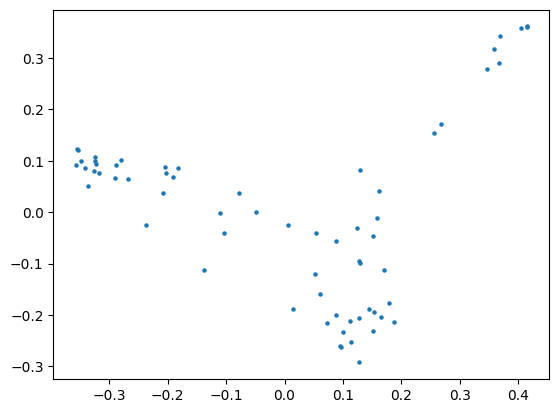

In [24]:
# Create scatter plot of the first two PCoA axes
plt.scatter(
    x=pc.samples['PC1'],
    y=pc.samples['PC2'],
    s=5);

...but that's not that interesting. Let's add some color. We're going to do this a couple of times so let's write a small function.

**NOTE**: We also recommend [EMPeror](https://academic.oup.com/gigascience/article/2/1/2047-217X-2-16/2656132) for large scale visualization. It is compatible with the `OrdinationResults` object, supports interactive operation and various brushing options.

In [25]:
# Defines a function to create PCoA (Principal Coordinates Analysis) plots
def pcoa_plot(ord_result, sample_metadata, category, title=None):
    # Initialize a square figure (7x7 inches) for the plot
    plt.figure(figsize=(7, 7))
    
    # Dynamic point sizing: smaller points (s=5) for large datasets (>300 samples),
    # larger points (s=10) for smaller datasets
    if len(ord_result.samples) > 300:
        s = 5  # Small point size
    else:
        s = 10  # Default point size
    
    # List to store legend labels
    labels = []
    
    # Get sample IDs present in the ordination results
    ord_ids = set(ord_result.samples.index)
    
    # Extract the metadata column of interest as a pandas Series
    category_series = sample_metadata.get_column(category).to_series()
    
    # Iterate through each unique category value (e.g., environment types)
    for env in category_series.unique():
        # Add current category to legend labels
        labels.append(env)
        
        # Get sample IDs belonging to current category that exist in ordination results
        env_ids = sample_metadata.get_ids(where=f"[{category}] = '{env}'")
        env_ids = list(env_ids & ord_ids)  # Intersection with available samples
        
        # Create scatter plot for current group
        plt.scatter(
            ord_result.samples.loc[env_ids, 'PC1'],  # X-axis: PC1 coordinates
            ord_result.samples.loc[env_ids, 'PC2'],  # Y-axis: PC2 coordinates
            s=s,              # Use dynamic point size
            alpha=0.75        # 75% opacity for better overlapping point visibility
        )
        
        # Configure plot axes
        ax = plt.gca()  # Get current axis
        # X-axis label with variance explained percentage
        ax.set_xlabel(f'PC1 ({100 * (ord_result.proportion_explained[0]):.2f}%)')
        # Y-axis label with variance explained percentage
        ax.set_ylabel(f'PC2 ({100 * (ord_result.proportion_explained[1]):.2f}%)')
        
        # Add legend with group labels
        plt.legend(labels)
        
        # Add optional title if provided
        if title is not None:
            plt.title(title)

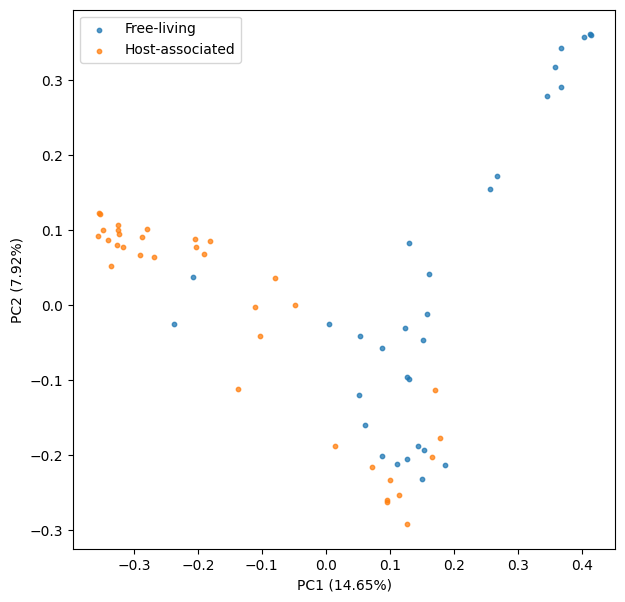

In [26]:
# Create pcoa plot using the defined function, using empo_1 as the category
pcoa_plot(
    ord_result=pc,
    sample_metadata=latam_metadata, 
    category='empo_1'
    )

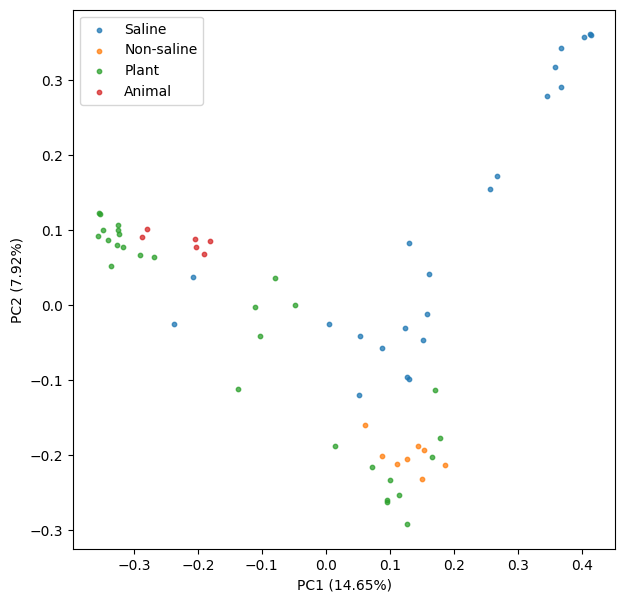

In [27]:
# Create pcoa plot using the defined function, using empo_2 as the category
pcoa_plot(
    ord_result=pc,
    sample_metadata=latam_metadata, 
    category='empo_2'
    )

**Statistical Validation with PERMANOVA**

To quantitatively assess the observed group differences, we will apply [PERMANOVA](https://onlinelibrary.wiley.com/doi/10.1111/j.1442-9993.2001.01070.pp.x)(Permutational Multivariate Analysis of Variance) to our distance matrix. This non-parametric method:

* Tests the null hypothesis that group centroids are equivalent in multivariate space
* Accounts for within-group variation when evaluating between-group differences
* Is particularly suited for ecological distance matrices like UniFrac

**Key Implementation Details**

1. **Permutation Approach**:
   * By default, performs 999 random permutations of group labels
   * Generates an empirical null distribution for p-value calculation
2. **Output Interpretation**:
   * **F-statistic**: Effect size (higher values indicate stronger group separation)
   * **p-value**: Statistical significance (typically evaluated at α=0.05)
3. **Biological Relevance**:
   * Identifies whether environmental/host factors significantly structure communities
   * Complements PCoA visualization with statistical rigor

In [28]:
# Import permanova from skbio.stats.distance
from skbio.stats.distance import permanova

In [29]:
# Make PERMANOVA analysis using the full distance matrix and the empo_1 metadata
permanova(
    distance_matrix=full_dm, 
    grouping=empo_1
    )

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      64
number of groups                  2
test statistic             5.596859
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [30]:
# Obtain the empo_2 column from the SampleMetadata object and convert it to a pandas Series
empo_2 = latam_metadata.get_column('empo_2').to_series()
permanova(
    distance_matrix=full_dm, 
    grouping=empo_2
    )

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      64
number of groups                  4
test statistic             3.933262
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

## Incorporating phylogeny

In [31]:
# Print the metadata object
latam_metadata

SampleMetadata
--------------
92 IDs x 33 columns
sample_name_original:          ColumnProperties(type='categorical', missing_scheme='blank')
sample_type:                   ColumnProperties(type='categorical', missing_scheme='blank')
collection_timestamp:          ColumnProperties(type='categorical', missing_scheme='blank')
country:                       ColumnProperties(type='categorical', missing_scheme='blank')
depth_sample:                  ColumnProperties(type='numeric', missing_scheme='blank')
description:                   ColumnProperties(type='categorical', missing_scheme='blank')
elevation:                     ColumnProperties(type='numeric', missing_scheme='blank')
emp500_principal_investigator: ColumnProperties(type='categorical', missing_scheme='blank')
emp500_study_id:               ColumnProperties(type='numeric', missing_scheme='blank')
emp500_pi_study_id:            ColumnProperties(type='categorical', missing_scheme='blank')
emp500_title:                  ColumnPrope

In [32]:
# Create Table object from a latam_ogu BIOM file
latam_shotgun = Table.read(f'{HOME}/latam/shotgun/latam_ogu.biom')
latam_shotgun

14933 x 68 <class 'biom.table.Table'> with 90562 nonzero entries (8% dense)

In [33]:
# Import table from skbio
from skbio import table

In [34]:
# Create path to the latam_ogu.tax file
latamtax_path = HOME + "shotgun/latam_ogu.tax"

# Read the latam_ogu.tax file into a pandas DataFrame
latam_tax = pd.read_csv(
    filepath_or_buffer=latamtax_path, 
    sep='\t', 
    low_memory=False, 
    header=None,
    index_col=0
    )
latam_tax

,1
0,
G000005825,d__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...
G000006175,d__Archaea; p__Methanobacteriota_A; c__Methano...
G000006605,d__Bacteria; p__Actinobacteriota; c__Actinomyc...
G000006725,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
G000006745,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
...,...
G902826025,d__Bacteria; p__Actinobacteriota; c__Acidimicr...
G902826465,d__Bacteria; p__Acidobacteriota; c__Vicinamiba...
G902826605,d__Bacteria; p__Acidobacteriota; c__Acidobacte...


In [35]:
# Get all sample IDs from the rarefied table (even_table)
sample_ids = even_table.ids()

# Create a dictionary to map each sample ID to its corresponding taxonomic information
samples_represented = {
    id_: set(sample_ids[v.indices])             # Convert to set for faster lookup
    for v, id_, _ in even_table.iter(axis='observation', dense=False)
    }

In [36]:
# Import reduce from functools and or_ from operator
from functools import reduce
from operator import or_

In [37]:
# Traverse the phylogenetic tree in post-order
for node in phylogeny.postorder():
    
    # Check if current node is a tip/leaf (terminal node)
    if node.is_tip():
        # For tip nodes:
        # 1. Store which samples contain this organism by looking up its name 
        #    in samples_represented dictionary (empty set if not found)
        node.samples_represented = samples_represented.get(node.name, set())
        
        # 2. Initialize tips_represented with just this tip's name
        node.tips_represented = {node.name, }

    else:
        # For internal nodes (ancestors):
        # 1. Aggregate samples_represented from all child nodes using set union (OR operation)
        node.samples_represented = reduce(or_, [child.samples_represented for child in node.children])
        
        # 2. Aggregate tips_represented from all child nodes using set union
        node.tips_represented = reduce(or_, [child.tips_represented for child in node.children])

In [38]:
# Iterate through each immediate child node of the phylogeny's root
for child in phylogeny.children:
    
    # Print information about samples containing each child clade:
    # - child.name: The identifier/name of the current child node
    # - len(child.samples_represented): Counts how many samples contain organisms from this clade
    print(f"Samples with {child.name}: {len(child.samples_represented)}")

Samples with N2: 26
Samples with N3: 64


In [39]:
# Import itemgetter from operator
from operator import itemgetter

In [ ]:
# Create a list of tuples containing information about named phylogenetic nodes:
# Each tuple contains:
# - n.name: The taxonomic identifier of the node (e.g., p__Proteobacteria)
# - len(n.samples_represented): Count of samples containing this phylogenetic group
# - n: The actual node object itself
# Only includes nodes that:
# 1. Have a name (n.name is not None)
# 2. Represent phylum-level taxa (names starting with 'p__')
named_nodes = [(n.name, len(n.samples_represented), n)
               for n in phylogeny.traverse()
               if n.name is not None and n.name.startswith('p__')]

# Sort the nodes by their sample count in descending order
# itemgetter(1) selects the count (second element) for sorting
named_nodes = sorted(named_nodes, key=itemgetter(1), reverse= True)

# Print the top 10 most prevalent phyla and their sample counts
# The underscore (_) ignores the node object in the unpacked tuple
for name, count, _ in named_nodes[:10]:
    print(f"Samples with {name}: {count}")

In [53]:
# Iterate through each immediate child node of the phylogeny's root
for child in phylogeny.children:
    
    # Print information about samples containing each child clade:
    # - child.name: The identifier/name of the current child node
    # - len(child.samples_represented): Counts how many samples contain organisms from this clade
    print(f"Samples with {child.name}: {len(child.samples_represented)}")

Samples with N2: 23
Samples with N3: 64


In [54]:
def intersect_with_node(tab, node):
    # Get all feature IDs (e.g., OTUs/ASVs) present in the table as a set
    tips_in_table = set(tab.ids(axis='observation'))
    
    # Calculate intersection between:
    # 1. Tips represented in this phylogenetic node (from tree traversal)
    # 2. Features actually present in our table
    tipset = node.tips_represented & tips_in_table
    
    # Return a filtered version of the table that:
    # 1. Only keeps features present in both the node AND table (tipset)
    # 2. Operates on the observation axis (features/rows)
    # 3. Creates a new table (inplace=False)
    # 4. Removes any samples that end up with zero counts
    return tab.filter(tipset, axis='observation', inplace=False).remove_empty()

In [ ]:
# Unpack the first element of named_nodes (top phylum) into three variables:
# - first_name: The taxonomic name (e.g., 'p__Proteobacteria')
# - _: Discards the sample count (not needed here)
# - first_node: The actual phylogenetic node object
first_name, _, first_node = named_nodes[0]

# Unpack the third element of named_nodes (third phylum) in same way
# Note: Using index [2] for the third position (0-indexed)
second_name, _, second_node = named_nodes[2]

# Create a rarefied table for the top phylum:
# 1. intersect_with_node() filters the full latam_shotgun table to only include
#    features belonging to this phylum (first_node)
# 2. subsample() performs rarefaction to the specified depth
even_table_first = intersect_with_node(latam_shotgun, first_node).subsample(depth)

# Repeat the process for the third phylum
even_table_second = intersect_with_node(latam_shotgun, second_node).subsample(depth)


Error: named_nodes does not contain enough phylum-level nodes. Please check the tree and node naming.


## Mantel test

In [43]:
from skbio.stats.distance import mantel

In [44]:
r, p, _ = mantel(first_dm, empo_1)
print(f"Mantel r={r:0.2} p={p:0.2}")

NameError: name 'first_dm' is not defined

## NMDS

In [3]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
# prompt: genera un dataframe de las distancias de full_dm con nombre de columna y renglon la muestra correspondiente

import pandas as pd
import seaborn as sns
# Generate a pandas DataFrame from the distance matrix
full_dm_df = pd.DataFrame(full_dm.data, index=full_dm.ids, columns=full_dm.ids)

# Print the first few rows of the DataFrame
print(full_dm_df.head())
nmds = MDS(n_components=2, dissimilarity='precomputed', metric=False, random_state=42)
nmds_coords = nmds.fit_transform(full_dm_df.values)

plt.scatter(nmds_coords[:, 0], nmds_coords[:, 1])
plt.title("NMDS (Unifrac)")
plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.grid(True)
plt.show()

# Use the filter method provided by SampleMetadata
valid_sample_names = full_dm_df.index.intersection(sample_metadata.ids()) # Ensure valid_sample_names are in sample_metadata ids
filtered_sample_metadata = sample_metadata.filter(valid_sample_names)

# Access the 'empo_1' column as a pandas Series for plotting
empo_1_series = filtered_sample_metadata.get_column('empo_1').to_series()


sns.scatterplot(x=nmds_coords[:, 0], y=nmds_coords[:, 1],
                hue=empo_1_series, palette='Set2')
plt.title("NMDS colored by empo_1") # Updated title to reflect column name
plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'full_dm' is not defined

...but that's not that interesting. Let's add some color. We're going to do this a couple of times so let's write a small function.

**NOTE**: We also recommend [EMPeror](https://academic.oup.com/gigascience/article/2/1/2047-217X-2-16/2656132) for large scale visualization. It is compatible with the `OrdinationResults` object, supports interactive operation and various brushing options.  

In [ ]:
def pcoa_plot(ord_result, metadata, category, title=None):
    plt.figure(figsize=(7, 7))

    # adjust the point size based on the number of samples
    if len(ord_result.samples) > 300:
        s = 5
    else:
        s = 10

    labels = []

    ord_ids = set(ord_result.samples.index)
    category_series = metadata.get_column(category).to_series()
    for env in category_series.unique():
        labels.append(env)

        env_ids = metadata.get_ids(where=f"[{category}] = '{env}'")
        env_ids = list(env_ids & ord_ids)

        plt.scatter(ord_result.samples.loc[env_ids, 'PC1'],
                    ord_result.samples.loc[env_ids, 'PC2'],
                    s=s, alpha=0.75)
    ax = plt.gca()
    ax.set_xlabel(f'PC1 ({100 * (ord_result.proportion_explained[0]):.2f}%)')
    ax.set_ylabel(f'PC2 ({100 * (ord_result.proportion_explained[1]):.2f}%)')
    plt.legend(labels)
    if title is not None:
        plt.title(title)

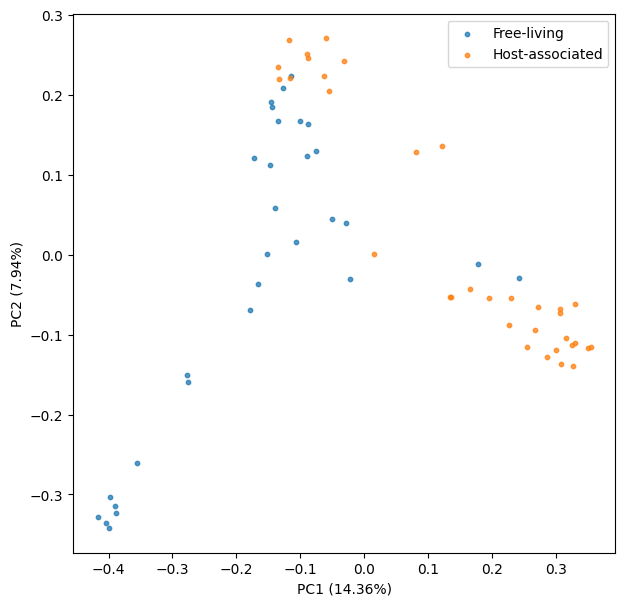

In [ ]:
pcoa_plot(pc, metadata, 'empo_1')

To support the above analyses, we will apply [PERMANOVA](https://onlinelibrary.wiley.com/doi/10.1111/j.1442-9993.2001.01070.pp.x) to the distances. PERMANOVA is a non-parametric analysis of variance. By default, PERMANOVA computes 999 permutations which is used to estimate the p-value.

In [ ]:
from skbio.stats.distance import permanova

In [ ]:
permanova(full_dm, empo_1)
#pseudo F is the same thanin Anova, If F is larger than 1, then the groups are different

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,64
number of groups,2
test statistic,5.463305
p-value,0.001
number of permutations,999


## Exercise # 1 Generate a Unifrac visualization with empo_2

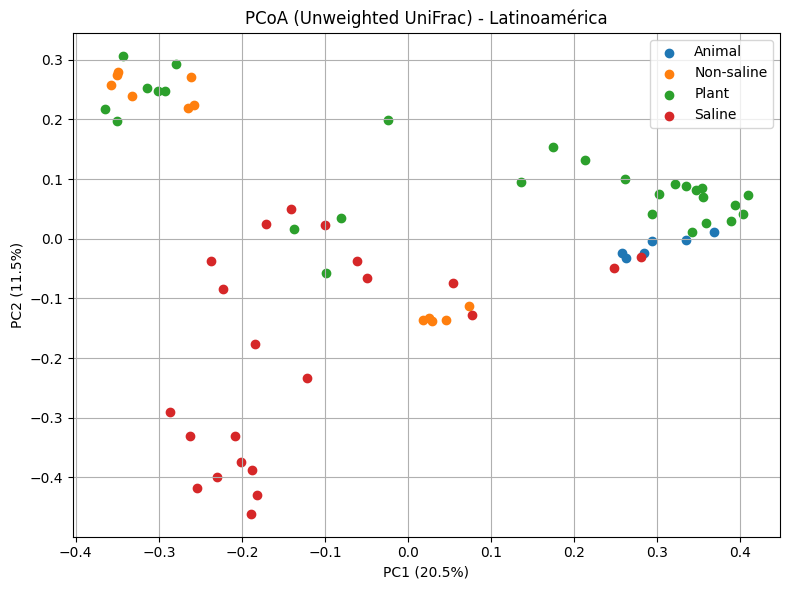

In [ ]:
# 6. Extraer matriz de datos
# Transpose the data array to have shape (number of samples, number of features)
data = tableShotgun.matrix_data.toarray().T  # Transpose the data array
sample_ids = tableShotgun.ids(axis='sample')
feature_ids = tableShotgun.ids(axis='observation') #This is the taxa argument

# 7. Calcular UniFrac (no ponderado)
unifrac_unweighted = beta_diversity(
    metric='unweighted_unifrac',
    counts=data,
    ids=sample_ids,
    tree=phylogeny,
    taxa=feature_ids #Adding the taxa argument
)

# 8. PCoA
pcoa_results = pcoa(unifrac_unweighted)
df_coords = pcoa_results.samples
df_coords['sample_id'] = df_coords.index

# 9. Unir coordenadas con metadata
merged = df_coords.join(LatamMeta_df, how='inner')

# 10. Visualizar PCoA con color
plt.figure(figsize=(8, 6))
for variable, group in merged.groupby('empo_2'):
    plt.scatter(group['PC1'], group['PC2'], label=variable)

plt.xlabel(f"PC1 ({round(pcoa_results.proportion_explained[0]*100, 1)}%)")
plt.ylabel(f"PC2 ({round(pcoa_results.proportion_explained[1]*100, 1)}%)")
plt.title("PCoA (Unweighted UniFrac) - Latinoamérica")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Extra material. Incorporating phylogeny in Mantel test

###Label your phylogeny

In [ ]:
# prompt: generate the metadata path by joining github_data_path with "emp500/sample.tsv"
latamtax_path = github_data_path + "shotgun/latam_ogu.tax"
# Read the TSV file directly from the URL into a pandas DataFrame
tax_df = pd.read_csv(latamtax_path, sep='\t', low_memory=False, header=None,index_col=0)
taxonomy_dict = tax_df[1].to_dict()
tax_df.head()

,1
0,
G000005825,d__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...
G000006175,d__Archaea; p__Methanobacteriota_A; c__Methano...
G000006605,d__Bacteria; p__Actinobacteriota; c__Actinomyc...
G000006725,d__Bacteria; p__Proteobacteria; c__Gammaproteo...
G000006745,d__Bacteria; p__Proteobacteria; c__Gammaproteo...


In [ ]:
# prompt: print first 5 elements on phylum_dict

from itertools import islice
for key, value in islice(taxonomy_dict.items(), 5):
    print(f'{key}: {value}')

G000005825: d__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales_H; f__Bacillaceae_D; g__Bacillus_S; s__Bacillus_S pseudofirmus
G000006175: d__Archaea; p__Methanobacteriota_A; c__Methanococci; o__Methanococcales; f__Methanococcaceae; g__Methanococcus; s__Methanococcus voltae_A
G000006605: d__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Mycobacteriales; f__Mycobacteriaceae; g__Corynebacterium; s__Corynebacterium jeikeium
G000006725: d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Xylella; s__Xylella fastidiosa
G000006745: d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales; f__Vibrionaceae; g__Vibrio; s__Vibrio cholerae


In [ ]:
# --- Step 3: Attach taxonomy to tips ---
for tip in labeled_phylogeny.tips():
    #print(tip.name)
    if tip.name in taxonomy_dict:
        lineage = [level.strip() for level in taxonomy_dict[tip.name].split(';')]
        #print(lineage)
        tip.lineage = lineage  # store it as a custom attribute
        #print(tip.lineage)

    else:
        tip.lineage = []

NameError: name 'labeled_phylogeny' is not defined

In [ ]:
# --- Step 4: Recursively assign taxonomy to internal nodes ---
def assign_taxonomy(node):
    if node.is_tip():
        return node.lineage

    child_lineages = [assign_taxonomy(child) for child in node.children]

    # Find shared lineage prefix
    common = []
    for levels in zip(*child_lineages):
        if all(l == levels[0] for l in levels):
            common.append(levels[0])
        else:
            break

    node.lineage = common
    if common:
        node.name = common[-1]  # Assign the most specific shared level
    return common

assign_taxonomy(labeled_phylogeny)

NameError: name 'labeled_phylogeny' is not defined

In [ ]:


from io import StringIO

# Get Newick string
output = StringIO()
labeled_phylogeny.write(output, format='newick')
newick_str = output.getvalue()
print(newick_str)

NameError: name 'labeled_phylogeny' is not defined

In [ ]:
# prompt: find in tree a name that contain G000006605 but is not equal to G000006605

# Iterate through all nodes in the tree
for node in labeled_phylogeny.levelorder(include_self=True):
    # Check if the node name contains the substring and is not equal to the substring
    if 'G000315565' in node.name: #and node.name != 'G000006605':
      #phylum = taxonomy.split(";")[1].strip()
      print(node.name)


NameError: name 'labeled_phylogeny' is not defined

In [ ]:
labeled_phylogeny
print(labeled_phylogeny.find('G000315565').parent.parent.ascii_art())

NameError: name 'labeled_phylogeny' is not defined

### Incorporating phylogeny

Now, let's tinker.

We might wonder whether the sample-to-sample relationships are consistent when constrained to particular phyla.

To do this, we're going to aggregate sample information up the phylogeny (from tip to root). Specifically, we are going to determine the set of samples a feature is present in, and then push the unique sample IDs up the tree through a postorder traversal, effecively reducing the information.

While doing so, we are also going to cache the names of the features found within a clade simply to facilitate filtering later on.



In [ ]:
latamtree_path = github_data_path + "latam/shotgun/latam_ogu.nwk"
labeled_phylogeny = skbio.TreeNode.read(latamtree_path, format='newick')
labeled_phylogeny

<TreeNode, name: N1, internal node count: 14326, tips count: 14933>

Postorder means children are assured to be evaluted before parents. The TreeNode supports many types of traversals, and pleasant examples of common traversals can be found on [Wikipedia](https://en.wikipedia.org/wiki/Tree_traversal). Here, we will decorate these new attributes onto the tree.

The algorithm is:
1. if the object being evaluated is a tip
* get the samples represented (or the empty set)
* construct a set composed of only the feature name
2. else the object must be an internal node
* compute the set union of samples represented
* compute the set union of features represented

In [ ]:
from functools import reduce
from operator import or_

In [ ]:
sample_ids = even_table.ids()

# this complex dict comprehension maps a feature ID to the set of
# samples that feature was found it. The v.indices attribute is the
# index positions of the nonzero values within a SciPy sparse vector
samples_represented = {id_: set(sample_ids[v.indices])
                       for v, id_, _ in even_table.iter(axis='observation', dense=False)}

In [ ]:
for node in labeled_phylogeny.postorder():
    if node.is_tip():
        node.samples_represented = samples_represented.get(node.name, set())
        node.tips_represented = {node.name, }
    else:
        node.samples_represented = reduce(or_, [child.samples_represented for child in node.children])
        node.tips_represented = reduce(or_, [child.tips_represented for child in node.children])

Let's spot check what the representation is at the domain level.

In [ ]:
for child in labeled_phylogeny.children:
    print(f"Samples with {child.name}: {len(child.samples_represented)}")

Samples with N2: 63
Samples with N3: 64


Next, let's gather all phylum level named nodes (p__), sort them by how many samples are represented, and print the top few

In [ ]:
from operator import itemgetter

In [ ]:
for n in labeled_phylogeny.traverse():
  if n.name is not None and n.name.startswith('p__'):
    print(n.name)

In [ ]:
named_nodes = [(n.name, len(n.samples_represented), n)
               for n in labeled_phylogeny.traverse()
               if n.name is not None and n.name.startswith('p__')]

named_nodes = sorted(named_nodes, key=itemgetter(1), reverse=True)
for name, count, _ in named_nodes[:10]:
    print(f"Samples with {name}: {count}")

In [ ]:
named_nodes

NameError: name 'named_nodes' is not defined

In [ ]:
# A helper function to intersect a table with the features represented by a node

def intersect_with_node(tab, node):
    tips_in_table = set(tab.ids(axis='observation'))
    tipset = node.tips_represented & tips_in_table
    return tab.filter(tipset, axis='observation', inplace=False).remove_empty()

Now we will take two interesting sets. While testing this notebook, it was noted the number of sample IDs in common between Proteobacteria and Firmicutes_D, after rarefaction, was relatively low. So instead, let's look at Proteobacteria and Bacteroidota.

The next few cells filter the feature table to each phyla of focus, constrain them to the exact same set of IDs, compute UniFrac again, and then principal coordinates.

In [ ]:
first_name, _, first_node = named_nodes[0]
second_name, _, second_node = named_nodes[2]



NameError: name 'named_nodes' is not defined

In [ ]:
even_table_first = intersect_with_node(tableShotgun, first_node).subsample(depth)
even_table_second = intersect_with_node(tableShotgun, second_node).subsample(depth)

NameError: name 'intersect_with_node' is not defined

In [ ]:
common_ids = set(even_table_first.ids()) & set(even_table_second.ids())
even_table_first = even_table_first.filter(common_ids).remove_empty()
even_table_second = even_table_second.filter(common_ids).remove_empty()

NameError: name 'even_table_first' is not defined

In [ ]:
first_dm = beta_diversity('unweighted_unifrac', even_table_first, tree=phylogeny)
second_dm = beta_diversity('unweighted_unifrac', even_table_second, tree=phylogeny)

NameError: name 'even_table_first' is not defined

In [ ]:
first_pc = pcoa(first_dm, number_of_dimensions=10)
second_pc = pcoa(second_dm, number_of_dimensions=10)

NameError: name 'first_dm' is not defined

Now we can visualize these clade specific beta diversity calculations!

In [ ]:
pcoa_plot(first_pc, metadata, 'empo_1', first_name)

NameError: name 'first_pc' is not defined

In [ ]:
pcoa_plot(second_pc, metadata, 'empo_1', second_name)

NameError: name 'second_pc' is not defined

### Mantel test

We additionally can compute the correlation of the sample-sample relationships in both phyla using a [Mantel](https://pubmed.ncbi.nlm.nih.gov/6018555/) test. Mantel, like PERMANOVA, is non-parametric and by default uses 999 repetitions to estimate a p-value.

In the next few cells, we will compare Proteobacteria to Bacteroidota, Proteobacteria to the full tree, and Bacteroidota to the full tree. We then will apply PERMANOVA to these clade specific distance matrices.

Interestingly, we observe a relatively low correlation between these two phyla, and it seems the sample-sample relationships within Bacteroidota better recapitulate the full distance matrix. This observation is further supported by the relative difference in test statistics from PERMANOVA, where the statistic is larger between host and non-host samples.

In [ ]:
from skbio.stats.distance import mantel

In [ ]:
r, p, _ = mantel(first_dm, second_dm)
print(f"Mantel r={r:0.2} p={p:0.2}")

NameError: name 'first_dm' is not defined

In [ ]:
r, p, _ = mantel(full_dm, first_dm, strict=False)
print(f"Mantel r={r:0.2} p={p:0.2}")

Mantel r=0.75 p=0.001


In [ ]:
r, p, _ = mantel(full_dm, second_dm, strict=False)
print(f"Mantel r={r:0.2} p={p:0.2}")

Mantel r=0.77 p=0.001


In [ ]:
permanova(first_dm, empo_1)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,56
number of groups,2
test statistic,8.822204
p-value,0.001
number of permutations,999


In [ ]:
permanova(second_dm, empo_1)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,56
number of groups,2
test statistic,7.960979
p-value,0.001
number of permutations,999


### Proscrustes disparity

And last, we will compute the [Procrustes disparity](https://en.wikipedia.org/wiki/Procrustes_analysis), a measure of fit, between the clade specific ordinations.

Procrustes can also be permuted to estimate a p-value, however that is not directly supported at this time within scikit-bio. The procedure is relatively simple though: iterate N times, randomly shuffle the IDs of one of the matrices, recomptue Procrustes. This too is slated for inclusion directly in scikit-bio. And last, the EMPeror library (noted above) can plot Procrustes transforms linking the samples in both ordinations visually.

In [ ]:
from scipy.spatial import procrustes

In [ ]:
mtx1, mtx2, disparity = procrustes(
    first_pc.samples[['PC1', 'PC2']],
    second_pc.samples[['PC1', 'PC2']]
)
print(disparity)